In [ ]:
!git clone https://github.com/Mark-Vergouwen/CPD.git
%cd CPD
!ls
!pip install ruptures

In [1]:
# Import packages
import os
import pandas as pd
import ruptures as rpt
import matplotlib.pyplot as plt
import numpy as np 

# Import functions from GitHub
import sys
sys.path.append("scripts")
import preprocessing_df
import detect_changepoints
import detect_sessions
import plot_changepoints
import plot_changepoints_sessions
import plot_changepoints_sessions_multiple


# Import data from GitHub
batch_files = [f"FluviusPublicEV_batch_{i}.csv" for i in range(1, 11)]

# Read and combine all batch files
df_list = [pd.read_csv(os.path.join("data", file), delimiter=",") for file in batch_files]
df = pd.concat(df_list, ignore_index=True)

# Read and combine all batch files
df_list = [pd.read_csv(os.path.join("data", file), delimiter=",") for file in batch_files]
df = pd.concat(df_list, ignore_index=True)
df = df.copy()
df = df[(df["Elektrisch_Voertuig_Indicator"] == 1)]
df.rename(columns={
    "Volume_Afname_kWh": "afname_kwh",
    "Datum_Startuur": "datetime"
}, inplace=True)



## 1. Evaluating changepoints
This section (1) splits up the dataset into EAN-week datasets, (2) applies preprocessing function to the weekly dataset, (3) applies changepoint detection function on weekly dataset, (4) returns a dictionary with all the identified changepoints. 

In [3]:
from collections import defaultdict
from datetime import timedelta

# Results storage
results = defaultdict(lambda: defaultdict(dict))  # results[ean][month][week_start_date] = {...}

# Define EAN list (Now takes first 20 households with EV)
unique_eans = df['EAN_ID'].unique()[:20]

# Loop over EANs
for ean in unique_eans:
    df_ean = df[df['EAN_ID'] == ean].copy()

    df_ean['datetime'] = pd.to_datetime(df_ean['datetime'], errors='coerce')
    df_ean = df_ean.dropna(subset=['datetime'])
    
    # Loop over months
    for month in range(1, 12):
        df_month = df_ean[df_ean['datetime'].dt.month == month].copy()
        if df_month.empty:
            continue
        
        # Set datetime index to slide by date
        df_month = df_month.set_index("datetime").sort_index()

        # Define start and end of the month
        start_date = df_month.index.min().normalize()
        end_date = df_month.index.max().normalize()

        current_start = start_date

        # Loop over weeks
        while current_start + timedelta(days=6) <= end_date:
            current_end = current_start + timedelta(days=6)
            df_week = df_month.loc[current_start:current_end].copy()

            # Apply algorithm on non-overlapping intervals (if no data, move to next week)
            if df_week.empty:
                current_start += timedelta(days=7)
                continue
                
            try:
                # Preprocessing algorithm
                features_df = df_week.reset_index()
                features_df = preprocessing_df.preprocessing(features_df)

                # Changepoint detection
                aggregated_breakpoints, contrib_features_dict = detect_changepoints.detect_changepoints(features_df, 
                                                                                                        method = 'pelt', 
                                                                                                        model = 'l2', 
                                                                                                        penalty=3, 
                                                                                                        min_size_hours=2, 
                                                                                                        merge_tolerance_hours=4, 
                                                                                                        n_contributing_features = 2)


                # Session detection (only if breakpoints exist)
                sessions = []
                if aggregated_breakpoints:
                    sessions = detect_sessions.detect_sessions(
                        df=features_df.set_index("datetime"), 
                        aggregated_breakpoints=aggregated_breakpoints,
                        contrib_features_dict=contrib_features_dict,
                        max_kw_column="max_kw", 
                        threshold=1  
                    )

                # Store results
                results[ean][month][current_start.date()] = {
                    "breakpoints": aggregated_breakpoints,
                    "features": contrib_features_dict,
                    "sessions": sessions
                }

            except Exception as e:
                print(f"Error processing EAN {ean}, {month=}, week starting {current_start.date()}: {e}")

            # Move to next week
            current_start += timedelta(days=7)

## 2. Visualization of charging sessions over time

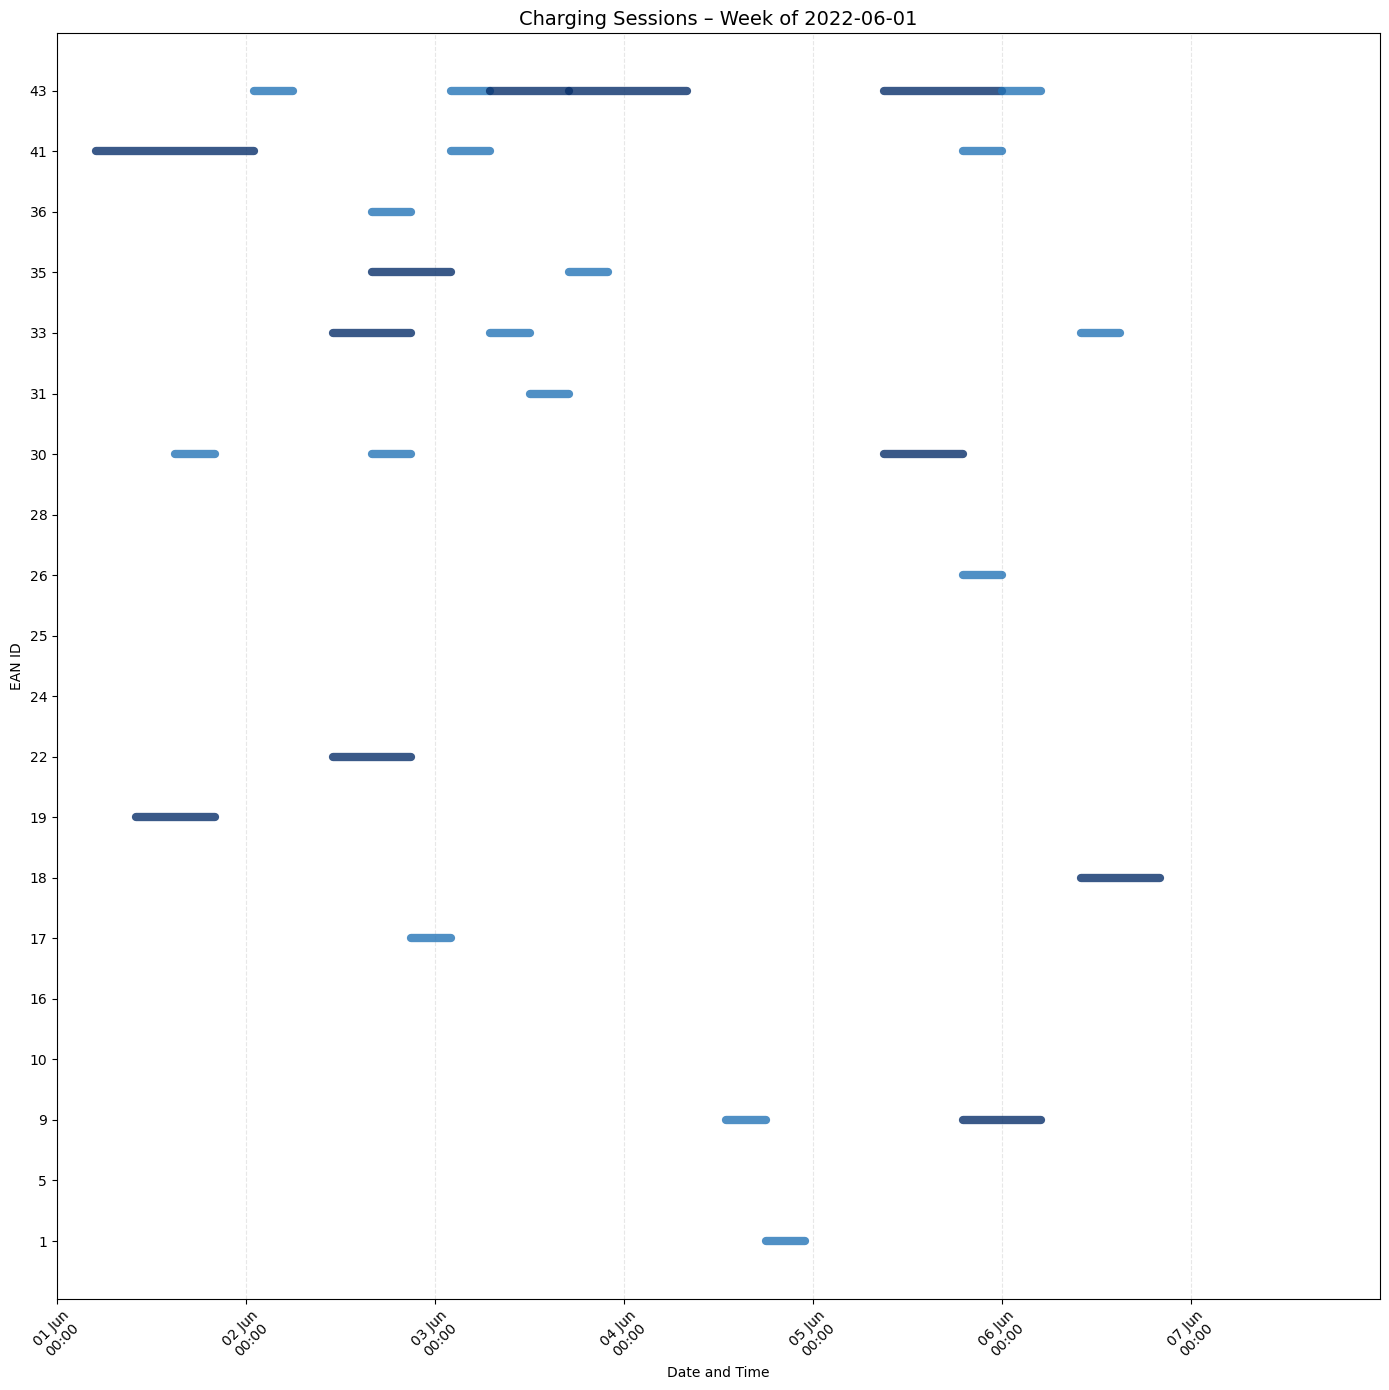

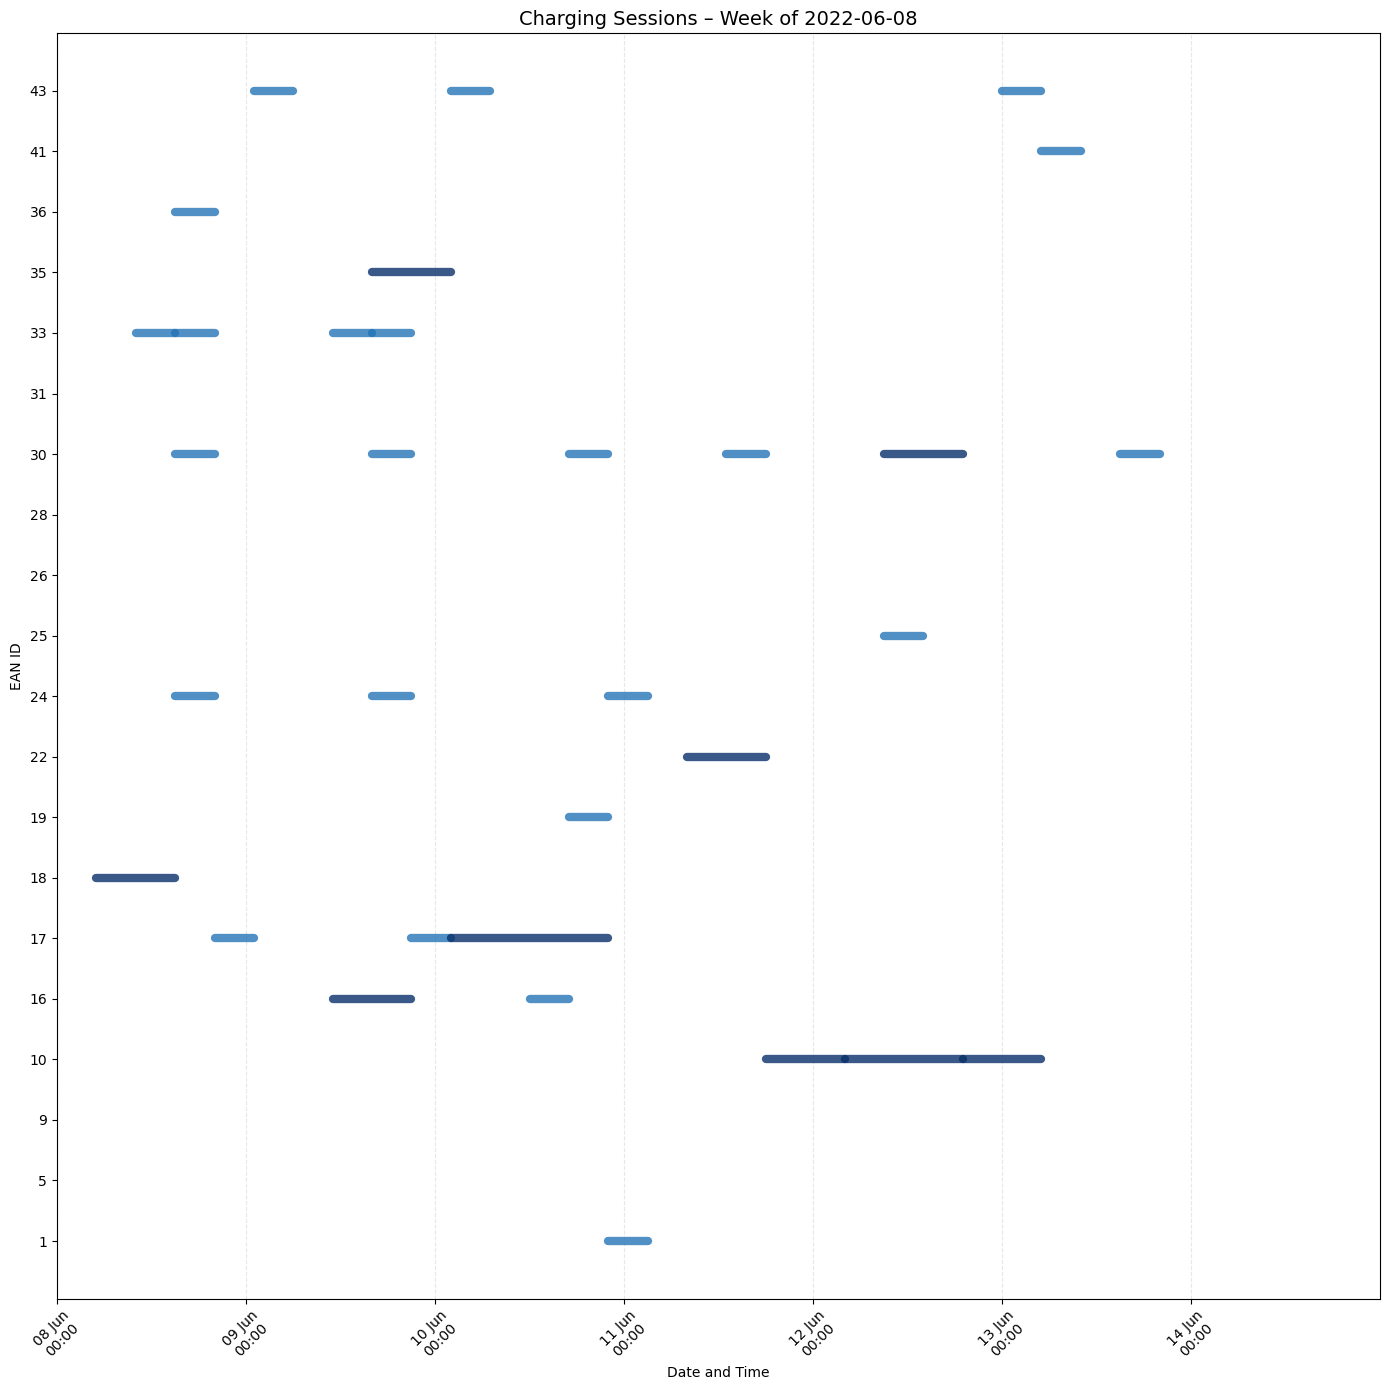

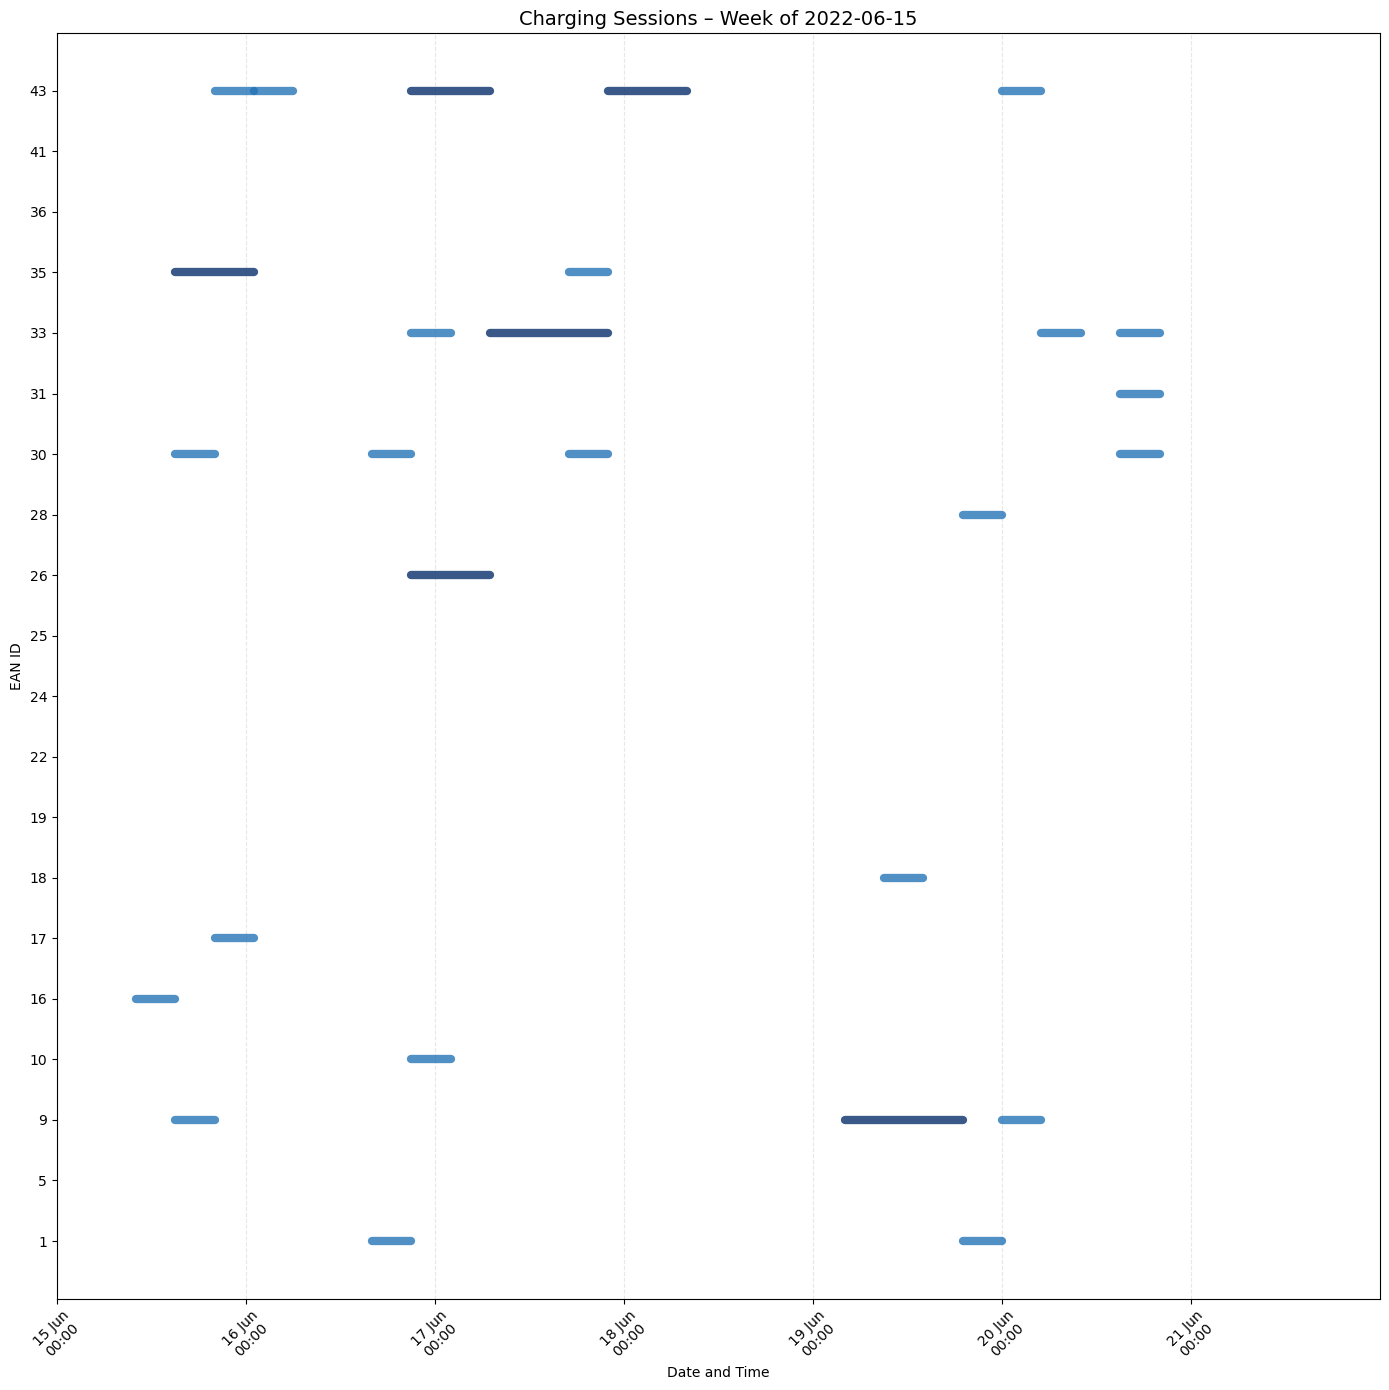

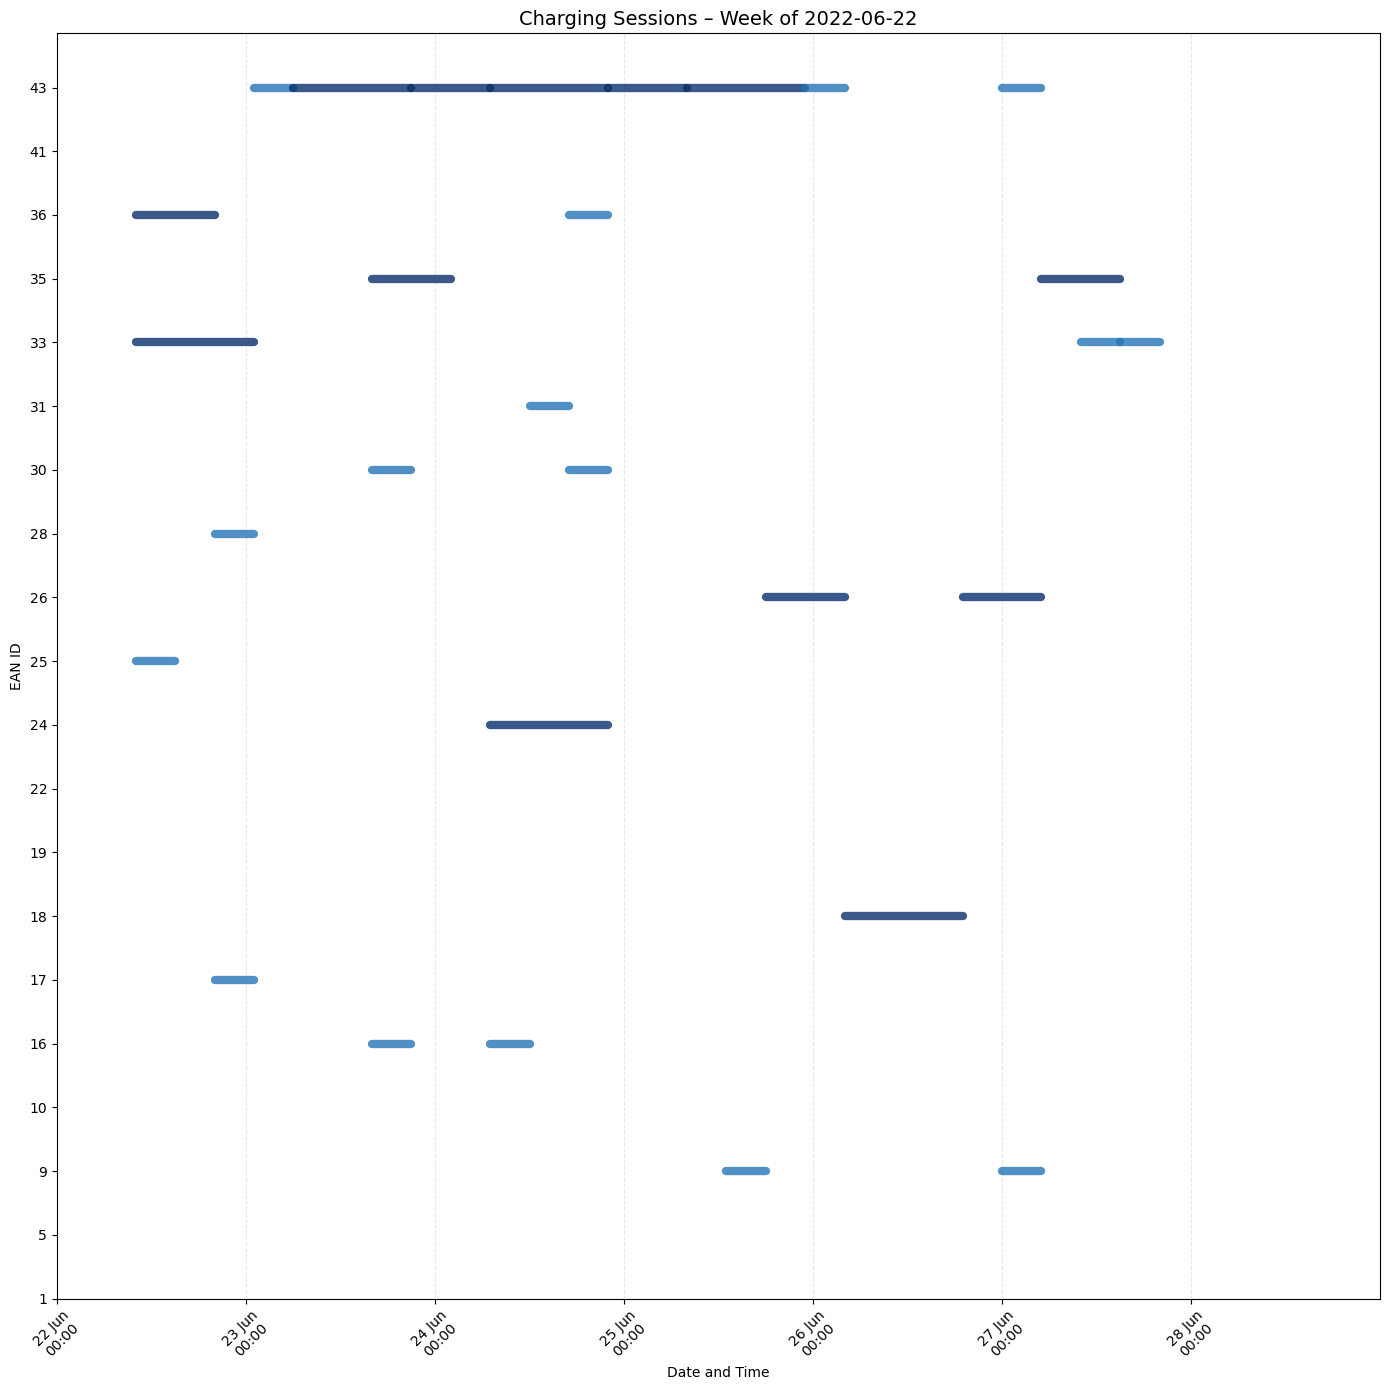

In [5]:
%matplotlib inline
plot_changepoints_sessions_multiple.plot_changepoints_sessions_multiple(results, month=6)